<a href="https://colab.research.google.com/github/HedersonSantos/jpx_tokyo/blob/main/jpx_tokyo_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
from google.colab import files, drive
from pathlib import Path
from sklearn.model_selection import train_test_split
import io, re, os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#import jpx_tokyo_market_prediction

from scipy.stats import norm
import statistics
from scipy import stats
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

In [66]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks/
path = '/gdrive/My Drive/Colab Notebooks'


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [67]:
dados = pd.read_csv('stock_prices.csv',index_col='Date', parse_dates=True).sort_values(by='Date')
dados.fillna(0,inplace=True)
dados.head(3)

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.000730
2017-01-04,20170104_7412,7412,719.0,725.0,719.0,721.0,201400,1.0,0.0,False,0.000000
2017-01-04,20170104_7408,7408,2459.0,2518.0,2447.0,2500.0,110900,1.0,0.0,False,0.004421


In [68]:
colunas=['Open','High','Low','Close','Volume']
alvo=['Target']
dados = dados[~dados['Target'].isna()]
dados = dados[~dados['Open'].isna()]
dados = dados[dados.index>='2021-12-01 00:00:00']
print(dados.shape)


(6000, 11)


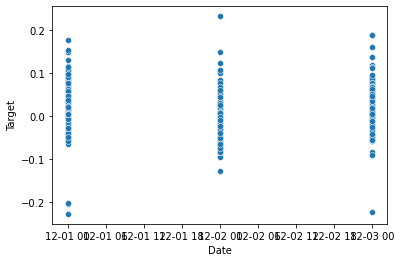

In [69]:
sns.scatterplot( x=dados.index, y=dados.Target)


In [70]:
df = dados.copy()
df = df[df.index>='2021-11-01 00:00:00']
fig = px.scatter( x=df.index, y=df.Target, title='Time Series for Target')
fig.show()

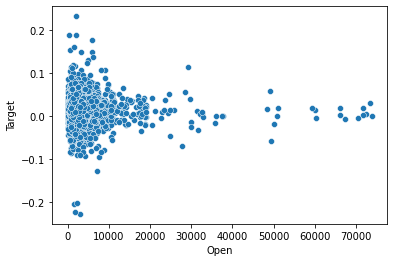

In [71]:
#sns.pairplot(dados[(','.join(colunas) + ',Target').split(',')])
#plt.show()
sns.scatterplot( x=dados.Open, y=dados.Target)


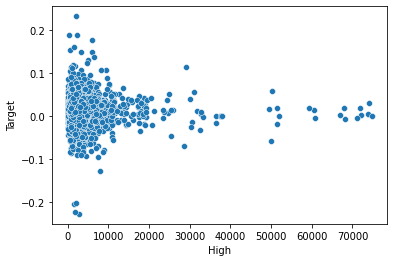

In [72]:
sns.scatterplot( x=dados.High, y=dados.Target)

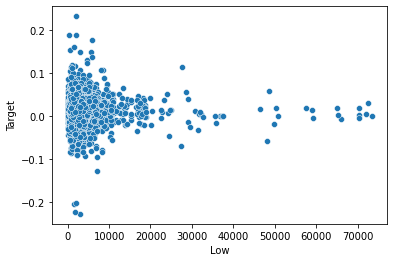

In [73]:
sns.scatterplot( x=dados.Low, y=dados.Target)

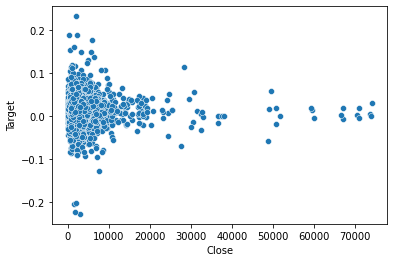

In [74]:
sns.scatterplot( x=dados.Close, y=dados.Target)

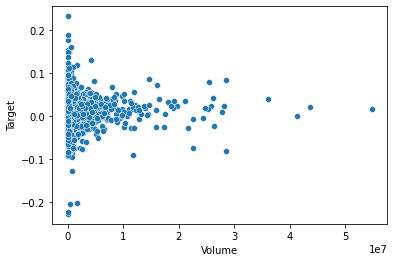

In [75]:
sns.scatterplot( x=dados.Volume, y=dados.Target)

In [76]:
dados[colunas].corr('pearson')

,Open,High,Low,Close,Volume
Open,1.000000,0.999903,0.999884,0.999799,-0.024421
High,0.999903,1.000000,0.999856,0.999909,-0.024090
Low,0.999884,0.999856,1.000000,0.999870,-0.024966
Close,0.999799,0.999909,0.999870,1.000000,-0.024319
Volume,-0.024421,-0.024090,-0.024966,-0.024319,1.000000


In [77]:
colunas

['Open', 'High', 'Low', 'Close', 'Volume']

In [78]:
from statsmodels.formula.api import ols

#Ajusta o modelo de regressão linear múltipla com Prestige como variável resposta
mod = ols('dados.Target ~  dados.High + dados.Low + dados.Close',data=dados)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           dados.Target   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     128.8
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.63e-81
Time:                        22:41:48   Log-Likelihood:                 13848.
No. Observations:                6000   AIC:                        -2.769e+04
Df Residuals:                    5996   BIC:                        -2.766e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0160      0.000     43.721      

In [79]:
#variancia do erro
res.mse_resid

0.0005795867844396153

In [80]:
# valores preditos de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

# objeto para a análise de pontos influentes
infl = res.get_influence()

# diagonal da matriz hat
hii = infl.hat_matrix_diag

# resíduo studentizado (internamente)
res_stud = infl.resid_studentized_internal

# resíduo studentizado com i-ésima observação deletada (externamente)
res_stud_del = infl.resid_studentized_external

# DFFITS
(dffits,p) = infl.dffits

# Distância de Cook
(cook,p) = infl.cooks_distance

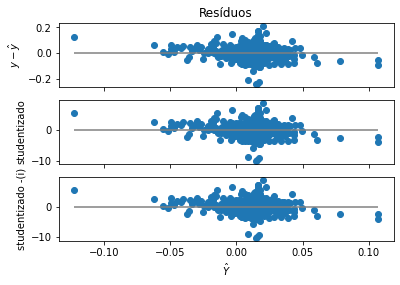

In [81]:
#gráfico dos resíduos
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(ypred, residuo)
ax1.set_ylabel('$y-\hat{y}$')
ax1.set_title('Resíduos')
ax1.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax2.scatter(ypred, res_stud)
ax2.set_ylabel('studentizado')
ax2.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.scatter(ypred, res_stud_del)
ax3.set_ylabel('studentizado -(i)')
ax3.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.set_xlabel('$\hat{Y}$')

for ax in fig.get_axes():
    ax.label_outer()

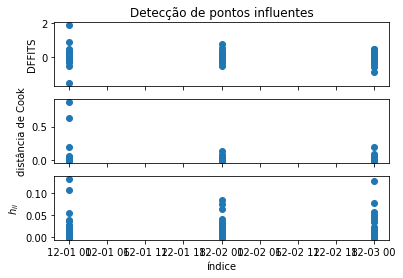

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(dados.index, dffits)
ax1.set_ylabel('DFFITS')
ax1.set_title('Detecção de pontos influentes')
#ax1.hlines(0,xmin=-10000,xmax=102,color='gray')
ax2.scatter(dados.index, cook)
ax2.set_ylabel('distância de Cook')
ax3.scatter(dados.index, hii)
ax3.set_ylabel('$h_{ii}$')
ax3.set_xlabel('índice')

for ax in fig.get_axes():
    ax.label_outer()

In [93]:
fig = px.scatter(x = dados.index, y=cook)
fig.show()

In [94]:
fig = px.scatter(x = dados.index, y=hii)
fig.show()

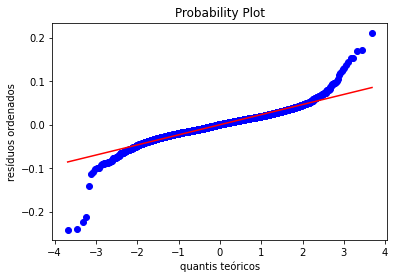

In [97]:
# Verificando a suposição de distribuição Normal dos resíduos
stats.probplot(residuo, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('resíduos ordenados')
plt.show()